In [1]:
import astropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema

In [2]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [3]:
data = data[['J2000.0', 'Type']]

In [4]:
data = data.to_pandas()

In [5]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [6]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [7]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [8]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [9]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [10]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [11]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [12]:
data.reset_index(drop=True, inplace=True)

In [13]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [14]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

In [15]:
################################################################

In [16]:
#Построение периодограммы (фурье спектра сигнала) для текущего значения obj_mag,obj_magerr,ang_freqs
# from astroML.time_series import lomb_scargle
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# power = lomb_scargle(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr), ang_freqs)

# # plot the results
# fig, ax = plt.subplots()
# ax.plot(periods, power)
# ax.set(ylim=(0, 0.8), xlabel='period (days)',
#        ylabel='Lomb-Scargle Power');

In [17]:
# peak_data = scipy.signal.find_peaks(power,prominence=0.05)
# f1=np.max(power[peak_data[0]])
# ind1=power[peak_data[0]].argmax()
# power[peak_data[0][ind1]]=0
# f2=np.max(power[peak_data[0]])
# ind2=power[peak_data[0]].argmax()
# print(periods[peak_data[0][ind1]])
# print(periods[peak_data[0][ind2]])
# print(periods[ind1])
# print(periods[ind2])

In [18]:
# model = LombScargleFast().fit(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr))

# period, power = model.periodogram_auto(nyquist_factor=200)

# print("period range: ({0}, {1})".format(period.min(), period.max()))
# print("number of periods: {0}".format(len(period)))
# print(type(periods))

In [19]:
data.shape

(54603, 4)

In [25]:
data1=data.iloc[0:3000]# Для быстрой загрузки с сервера

In [26]:
rows = np.random.choice(data.index.values, 3000)
print(data1.shape)
data1.head()

(3000, 4)


,coord,Type,ra,dec
0,002401.95 +383437.3,M,6.008125,38.577028
1,004243.1 +411605.0,SNI,10.679583,41.268056
2,002223.15 +265945.8,M,5.596458,26.996056
3,011529.70 +404308.4,M,18.873750,40.719000
4,005006.28 +353910.1,M,12.526167,35.652806


In [27]:
%%time
obj_mjd1={}
obj_mag1={}
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast
periods = np.linspace(0.01, 200, 500)
ang_freqs = 2 * np.pi / periods
my_data = pd.DataFrame({'obj_id':[],
                        'filter':[],
#                         'mean_magn':[],
#                         'amplitude':[],
#                         'trand_angle':[],
#                         'skew' : [],
#                         'std' : [],
#                         'max_PSD' : [],
#                         'max_fs' : [],
                        'pointsN': [],
                        'idN': [],
                        'dist':[],
#                         'dist1':[],
#                         'dist2':[],                        
                        'class':[]})
i=0
for item in data1.iterrows():
#     obj_mjd1[i]=obj_mjd
#     obj_mag1[i]=obj_mag
#     i=i+1
    a=item[1].ra*u.degree
    b=item[1].dec*u.degree
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
                                                                                                                  r=5))
        res = resp.json()
        if len(res.keys())==2:
            c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
            c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
            c3=SkyCoord(a,b)
            sep = c1.separation(c2)
#             sep1 = c3.separation(c1)
#             sep2 = c3.separation(c2)
            for obj_id in res.keys():
    #             if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=5):
                obj_mjd = []
                obj_mag = []
                obj_magerr = []
                object_return = {}
                obj_filter = res[obj_id]['meta']['filter']   
#                     for ii in res[obj_id]['lc']:
#                         obj_mjd.append(ii['mjd'])
#                         obj_mag.append(ii['mag'])
#                         obj_magerr.append(ii['magerr'])
    #                 Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
    #                 Fs = np.linspace(0.01, 10)
#                     model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
    #                 period, power = model.periodogram_auto(nyquist_factor=200)
#                     period=0
#                     power=0
                object_return['obj_id'] = obj_id
                object_return['filter'] = res[obj_id]['meta']['filter']
#                     object_return['mean_magn'] = np.array(obj_mag).mean()
#                     object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
#                     object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
#                     object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
                object_return['pointsN'] = len(res[obj_id]['lc'])
                object_return['idN'] = len(res.keys())
                object_return['dist'] = sep 
#                 object_return['dist1'] = sep1
#                 object_return['dist2'] = sep2
            
    #                 D1=np.max(power[peak_data[0]])
    #                 ind1=power[peak_data[0]].argmax()
    #                 power[peak_data[0][ind1]]=0
    #                 D2=np.max(power[peak_data[0]])
    #                 ind2=power[peak_data[0]].argmax() 
#                     object_return['max_fs'] =0
#                     object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
    #                 object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
#                     object_return['max_PSD'] = np.max(power)
    #                 object_return['max_PSD1'] = D2
#                     object_return['std'] = np.array(obj_mag).std()
                my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
                                                          'filter' : [ object_return['filter'] ],
#                                                           'mean_magn' :[ object_return['mean_magn'] ],
#                                                           'amplitude' : [ object_return['amplitude'] ], 
#                                                           'trand_angle' : [ object_return['trand_angle'] ],
#                                                           'skew' : [ object_return['skew'] ],
#                                                           'std' : [ object_return['std'] ],
#                                                           'max_PSD' : [ object_return['max_PSD']],
#                                                           'max_fs' : [ object_return['max_fs'] ],
                                                          'pointsN' : [ object_return['pointsN']],
                                                          'idN' : [ object_return['idN']],
                                                          'dist' : [ object_return['dist']],
#                                                           'dist1' : [ object_return['dist1']], 
#                                                           'dist2' : [ object_return['dist2']],                                                           
                                                          'class' : [ item[1].Type ] }),
                                             ignore_index = True)

    except Exception as ex:
        print("file {} has error".format(item[0]), ex)

    if item[0] % 1000 == 0 :
        my_data.to_csv('backup_' + str(item[0]) + '.csv')


file 2720 has error Extra data: line 1 column 5 (char 4)
Wall time: 6min 37s


In [28]:
my_data.head()

,obj_id,filter,pointsN,idN,dist,class
0,649105100012433,zg,44.0,2.0,0d00m00.0978s,M
1,650108200003776,zg,47.0,2.0,0d00m00.0978s,M
2,734105200007800,zg,45.0,2.0,0d00m00.1702s,M
3,734205200033834,zr,51.0,2.0,0d00m00.1702s,M
4,601113300001178,zg,50.0,2.0,0d00m00.036s,EA


C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261344AA5C0>]],
      dtype=object)

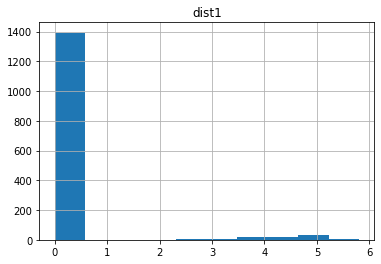

In [29]:
my_data['dist1']=0
for i in range(1,1282):
    my_data['dist1'][i]=my_data['dist'][i]*3600
my_data.hist(column="dist1")
#распределение по расстоянию для ответов с 2ID (3000 рандомных запрсов)

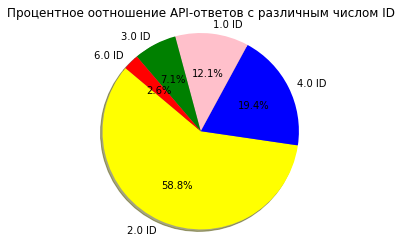

In [30]:
# my_data.head(20)
# my_data['idN'].value_counts().nlargest(n=5)  # пять самых больших классов
labels = '2.0 ID', '4.0 ID', '1.0 ID', '3.0 ID','6.0 ID'
sizes = [1346, 444, 277, 162,60] # Размеры пяти самых больших классов
colors = ['yellow', 'blue', 'pink', 'green','red']
explode = (0.1, 0, 0, 0)  # explode 1st slice
# Plot
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title ("Процентное оотношение API-ответов с различным числом ID") # данные для 3000 рандомных запросов
plt.show()

Text(0.5, 1.0, 'Распределение по расстоянию ОКПЗ-ZTF для ответов с 1 ID')

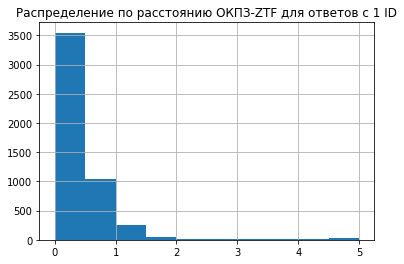

In [31]:
df = pd.read_csv(r'1IDobj.csv',sep='\t')
df['dist1']=df['dist1']
df['dist1'].hist()
plt.title ("Распределение по расстоянию ОКПЗ-ZTF для ответов с 1 ID") #данные по всему каталогу 

In [ ]:
df.head()

In [ ]:
my_data.to_csv('1IDobj-.csv', sep='\t')

In [ ]:
# оставляем только популярные классы

In [ ]:
largest_classes = list(df['class'].value_counts().nlargest(n=5).index)

In [ ]:
largest_classes

In [ ]:
to_replace = list(set(df['class'].values) - set(largest_classes))

In [ ]:
df['class'].replace(list(to_replace), 'OTHER', inplace=True)

In [ ]:
df.shape

In [ ]:
df['class'].value_counts().nlargest(n=5)

In [ ]:
# df.to_csv('prepared_data.csv')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.metrics import accuracy_score

In [ ]:
data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
RandomForestClassifier

In [ ]:
df1=df.iloc[1500:1725]
array = data1.values
X = array[:,0:7]
Y = array[:,7]
validation_size = 0.2
seed = 5
X_train=X[0:1500]
X_validation=X[1500:1725]
Y_train=Y[0:1500]
Y_validation=Y[1500:1725]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
print(Y)
# train.head()

In [ ]:
#Learning with XGB model
model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
model.fit(X_train,Y_train)
pred = model.predict(X_validation)
accuracy = accuracy_score(Y_validation, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
df1['pred']=pred
df1.head(1000)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.array(obj_mjd1[9]), np.array(obj_mag1[9]))

In [ ]:
obj_mag